# Convert to $q$ space & visualise data

In [27]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import fabio

from id01lib import id01h5
from id01lib.xrd.qconversion import scan_to_qspace_h5,qconvert_mgrid
from id01lib.xrd.geometries import ID01psic
from id01lib.xrd.detectors import Eiger2M
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle

from scipy.signal import savgol_filter
import peakutils as pk

# for Silx / mayavi to work
%gui qt5

## Inspect edf imgs

Visualise raw `.edf` images if needed. Make sure the right directory and starting image are specified.

In [30]:
%ls /data/id01/inhouse/IHR/ihhc3501/detector/

align/  AuSiC4/  Beutier/  kmap/  zaptest/


In [33]:
## inspect raw edf imgs

%matplotlib inline
d = '/data/id01/inhouse/IHR/ihhc3426/detector/e18016/'
first_img = !ls {d} | grep mpx | grep '00000' 
n_files = !ls {d} -F |grep -v / | wc -l
n_files = int(n_files[0])

f=fabio.open('{0}/{1}'.format(d,first_img[0]))
# f=fabio.open('{0}/data_eiger2M_04033.edf.gz'.format(d))


@interact(i=(0,n_files-1,1))
def pl(i=0):
    plt.figure(figsize=(5,5),dpi=100)
    im = plt.imshow(np.log(f.getframe(i).data))
#     roi2 = Rectangle((224,320),22,32,edgecolor='red',facecolor='none')
#     roi3 = Rectangle((276,322),27,38,edgecolor='red',facecolor='none')
#     roi4 = Rectangle((197,440),30,41,edgecolor='red',facecolor='none')
#     roi5 = Rectangle((292,446),30,29,edgecolor='red',facecolor='none')
#     im.axes.add_patch(roi2)
#     im.axes.add_patch(roi3)
#     im.axes.add_patch(roi4)
#     im.axes.add_patch(roi5)

interactive(children=(IntSlider(value=0, description='i', max=9582), Output()), _dom_classes=('widget-interact',))

## Write data to h5

The following writes the chosen datasets to a specified `.h5` file. Wait for any given scan to be finished before running the cell, or set `overwrite=True` if only a part of a scan was written by mistake. EDIT - the function should now wait for a scan to be finished before attempting to write it! 

In [2]:
sample = 'e18030b'
specdir = '/data/id01/inhouse/IHR/ihhc3426/spec/'
h5file = './e18030b_marios.h5'
imgdir = '/data/id01/inhouse/IHR/ihhc3426/detector/e18030b/'

specfile = id01h5.id01SpecH5(specdir + 'e18030b.spec')
scanno = [14,16,21,22,23,27,31,33] # None for all 

with id01h5.ID01File(h5file,'a') as h5f:
    if sample not in h5f.keys():
        s = h5f.addSample(sample)
    else:
        s = h5f[sample]
    s.importSpecFile(specfile,
                     numbers=scanno,
                     verbose=True,
                     imgroot=imgdir,
                     overwrite=False, # skip if scan exists
                     compr_lvl=6)

Importing spec scan 16.1 from /data/id01/inhouse/IHR/ihhc3426/spec/e18030b.spec to /e18030b/16.1...
An Error ocurred... cleaning up...


TypeError: Object dtype dtype('O') has no native HDF5 equivalent

## Convert to $q$ space

Specify the correct experimental parameters.

In [62]:
# Sample and scans
fname = './e18030b.h5'
sample = 'e18030b'
scan_no = 33

# Experimental parameters
nrj=8
bins = (200,200,200)
# bins = (-1,-1,-1)

# Open the h5 file
geom = ID01psic()
with h5py.File(fname) as h5f:
    # read / set offsets
    scan = h5f['/{0}/{1}.1'.format(sample,scan_no)]
    phi_off = h5f['/{0}/{1}.1/instrument/positioners/phi'.format(sample,scan_no)].value
    rhx_off = h5f['/{0}/{1}.1/instrument/positioners/rhx'.format(sample,scan_no)].value
    rhy_off = h5f['/{0}/{1}.1/instrument/positioners/rhy'.format(sample,scan_no)].value
    nu_off =  h5f['/{0}/{1}.1/instrument/positioners/nu'.format(sample,scan_no)].value
    geom.usemotors = set(('eta', 'phi', 'nu', 'delta'))
    
    # set to corresponding offsets if needed
    geom.set_offsets(eta=-1.0402, rhy=0, rhx=0, phi=0, nu=0.)
    
    # convert to q space
    qx, qy, qz, gint = scan_to_qspace_h5(scan, 
                                         cen_pix=None, 
                                         distance=None, 
                                         energy=nrj,
                                         nbins=bins)

Selected /e18030b/33.1
Using center pixel from detector calibration: 223.09, 272.23
Using detector distance from detector calibration: 0.407m
Offsets used: delta = 0.0, rhx = 0.0, rhz = 0.0, rhy = 0.0, eta = -1.0402, mu = 0.0, phi = 0.0, nu = 0.0, 
Max. number of bins: 517, 248, 609
Using binning: (200, 200, 200)


### Grid q space

In [63]:
qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 8)


Gridding with bins: (200, 200, 200)


## Plot projections

Specify the resolution of the plots (good for having correctly-sized labels for powerpoints etc.)

In [64]:
res = 120 # in dpi

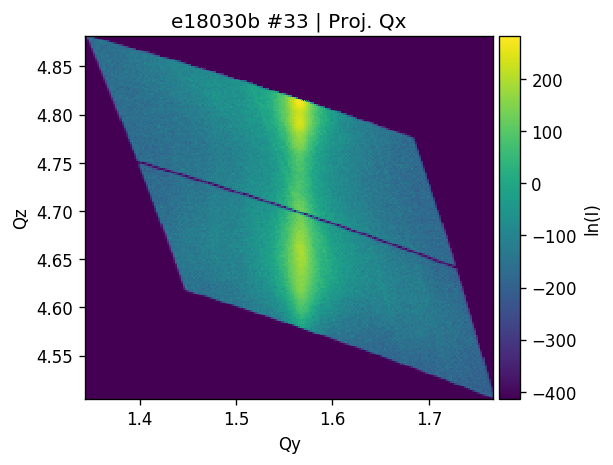

In [65]:
%matplotlib inline
## along x
plt.figure(dpi=res,facecolor='white')
ax=plt.gca()

# im = plt.pcolormesh(qyy[0,:,:],qzz[0,:,:],np.log(gint[:,:,:].sum(0)),vmin=5,vmax=10)
im = plt.pcolormesh(qyy[0,:,:],qzz[0,:,:],i[:,:,:].sum(0))
plt.title('{0} #{1} | Proj. Qx'.format(sample, scan_no))
plt.xlabel('Qy')
plt.ylabel('Qz')
plt.axis('image')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('ln(I)')

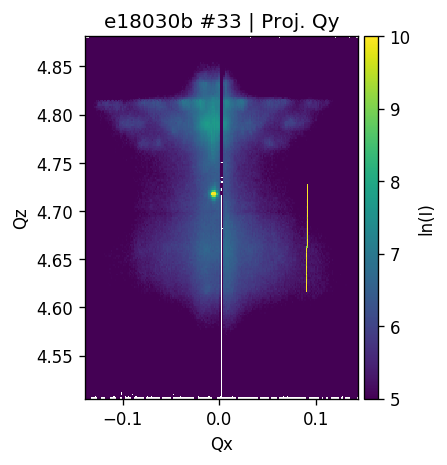

In [66]:
## along y
plt.figure(dpi=res,facecolor='white')
ax=plt.gca()

# plt.pcolormesh(qxx[:,0,:], qzz[:,0,:],i[:,:,:].sum(1));
im = plt.pcolormesh(qxx[:,0,:], qzz[:,0,:],np.log(gint[:,:,:].sum(1)),vmin=5, vmax=10)
plt.title('{0} #{1} | Proj. Qy'.format(sample, scan_no))
plt.xlabel('Qx')
plt.ylabel('Qz')
plt.axis('image')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('ln(I)')

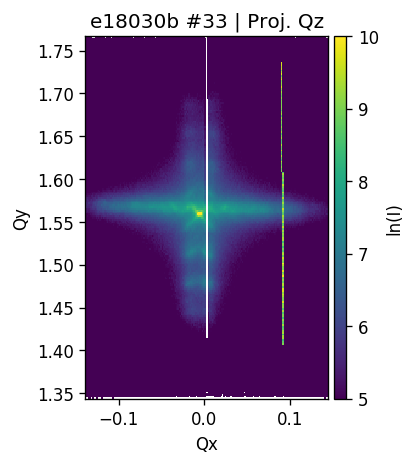

In [67]:
## along z
s=30
plt.figure(dpi=res,facecolor='white')
ax=plt.gca()
plt.title('{0} #{1} | Proj. Qz'.format(sample, scan_no))
# plt.title('Sum up to Qz={0:.3f}'.format(qzz[0,0,s]))
im = plt.pcolormesh(qxx[:,:,0],qyy[:,:,0],np.log(gint[:,:,:].sum(2)),vmin=5, vmax=10)
plt.axis('image')
# plt.axis([1.55,1.7,-0.13,0.17])
plt.xlabel('Qx')
plt.ylabel('Qy')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('ln(I)')

## Plot slices

interactive(children=(IntSlider(value=0, description='s', max=512), Output()), _dom_classes=('widget-interact',))

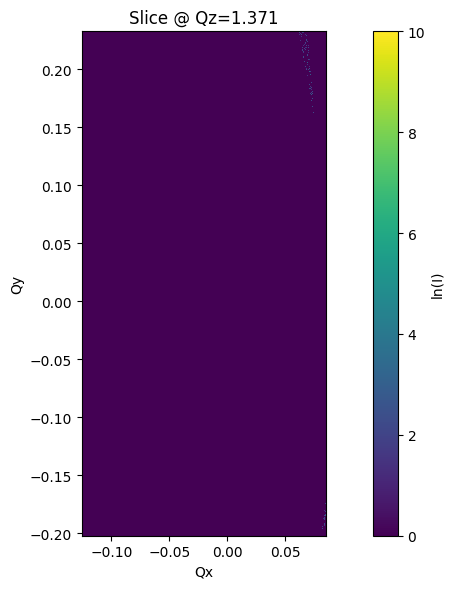

In [54]:
# # along z
# @interact(s=(0,i.shape[2]))
# def plot(s=0):
#     plt.figure(figsize=(4.6*2,3*2),dpi=res)
#     plt.title('Slice @ Qz={0:.3f}'.format(qzz[0,0,s]))
#     plt.pcolormesh(qxx[:,:,0], qyy[:,:,0],np.log(gint[:-1,:-1,s]),vmin=0,vmax=6);
#     bar = plt.colorbar()
#     bar.set_label('ln(I)')
#     plt.axis('image')
#     plt.ylabel('Qy')
#     plt.xlabel('Qx')
#     plt.tight_layout();
%matplotlib qt5
plt.figure(figsize=(4.6,3*2),dpi=100)
im = plt.pcolormesh(qxx[:,:,0], qyy[:,:,0],np.log(gint[:-1,:-1,0]),vmin=0,vmax=10);
bar = plt.colorbar()
bar.set_label('ln(I)')
# along z
@interact(s=(0,i.shape[2]))
def plot(s=0):
    plt.title('Slice @ Qz={0:.3f}'.format(qzz[0,0,s]))
    im.set_array(np.log(gint[:-1,:-1,s]).ravel())
    plt.axis('image')
    plt.ylabel('Qy')
    plt.xlabel('Qx')
    plt.tight_layout();

In [55]:
%matplotlib inline
# along x
@interact(s=(0,i.shape[0]))
def plot(s=0):
    plt.figure(figsize=(8,6))
    plt.title('Slice @ Qx={0:.3f}'.format(qxx[s,0,0]))
    plt.pcolormesh(qyy[0,:,:],qzz[0,:,:],np.log(gint[s,:-1,:-1]));
    plt.ylabel('Qz')
    plt.xlabel('Qy')
    plt.axis('image')

interactive(children=(IntSlider(value=0, description='s', max=671), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=0, description='s', max=377), Output()), _dom_classes=('widget-interact',))

/users/zatterin/Envs/py3/lib/python3.5/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/users/zatterin/Envs/py3/lib/python3.5/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


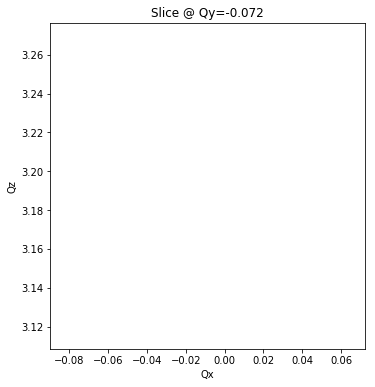

In [342]:
# along y
@interact(s=(0,i.shape[0]))
def plot(s=0):
    plt.figure(figsize=(8,6))
    plt.title('Slice @ Qy={0:.3f}'.format(qyy[0,s,0]))
    plt.pcolormesh(qxx[:,0,:],qzz[:,0,:],np.log(gint[:-1,s,:-1]));
    plt.ylabel('Qz')
    plt.xlabel('Qx')
    plt.axis('image')

## Mayavi nb

Have a quick look at the 3D contour of the q-converted intensity. Uncomment the `init_notebook` line to spawn an interactive window if notebook is run locally. The inline interactive `x3d` backend does not display correctly all the contours - work in progress.

In [46]:
from mayavi import mlab
mlab.options.backend = 'simple' # 'envisage' for the full mayavi2 application to be launched.
mlab.init_notebook(backend='x3d', local=False, width=200, height=200) # 'x3d' backend for inline interactivity

Notebook initialized with x3d backend.


In [ ]:
mlab.figure(size=(200,200))
mlab.clf()
mlab.contour3d(qxx,qyy,qzz,i,contours=10,opacity=0.5) # transparent=True for opacity that scales with scalar value
mlab.axes()

## calc com

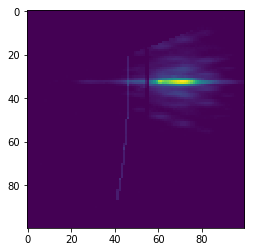

In [168]:
plt.imshow(i.sum(1))

In [185]:
zRoi = (60, 80) 
yRoi = (40, 60)
xRoi = (20, 40) 

In [186]:
iroi = np.s_[xRoi[0]:xRoi[1],yRoi[0]:yRoi[1],zRoi[0]:zRoi[1]]
roi, qxr, qyr, qzr = [array[iroi] for array in (gint, qxx, qyy, qzz)]

In [187]:
take = int(100)
# print(take/roi.size*100)
isort = roi.ravel().argsort()[::-1][:take]
roisort = roi.ravel()[isort]  - roi.ravel()[isort].min()
qCOM = [(arr.ravel()[isort]*roisort).sum() / roisort.sum() for arr in (qxr,qyr,qzr)]
print(qCOM)

[-0.001270013922316995, -0.0006458833065424088, 6.37904855535042]


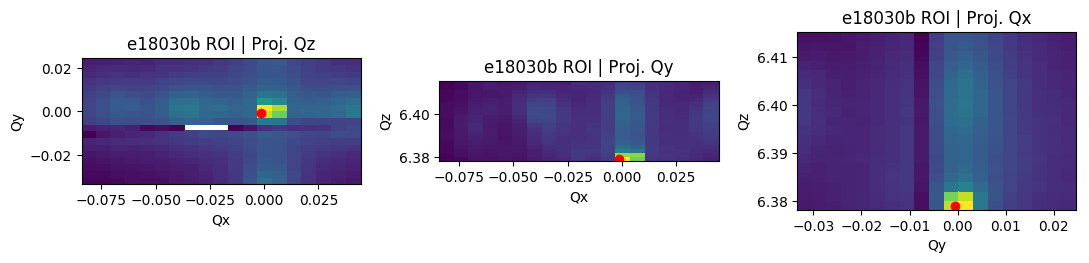

In [188]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(11,4),dpi=100)

ax1.set_title('{0} ROI | Proj. Qz'.format(sample))
ax1.pcolormesh(qxr[:,:,0],qyr[:,:,0],np.log(roi.sum(axis=2)))
ax1.set_ylabel('Qy');ax1.set_xlabel('Qx')
ax1.scatter(qCOM[0],qCOM[1],c='r')
ax1.set_aspect('equal')

ax2.set_title('{0} ROI | Proj. Qy'.format(sample))
ax2.pcolormesh(qxr[:,0,:],qzr[:,0,:],np.log(roi.sum(axis=1)))
ax2.set_ylabel('Qz');ax2.set_xlabel('Qx')
ax2.scatter(qCOM[0],qCOM[2],c='r')
ax2.set_aspect('equal')

ax3.set_title('{0} ROI | Proj. Qx'.format(sample))
ax3.pcolormesh(qyr[0,:,:],qzr[0,:,:],np.log(roi.sum(axis=0)))
ax3.set_ylabel('Qz');ax3.set_xlabel('Qy')
ax3.scatter(qCOM[1],qCOM[2],c='r')
ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

In [189]:
qxp, qyp, qzp = qCOM
Q = np.sqrt(qxp**2+qyp**2+qzp**2)
_001 = (2*np.pi)/Q
ang = np.rad2deg(np.arcsin((np.sqrt(qxp**2+qyp**2)/Q)))

print('|Q|={0}'.format(np.round(4*_001,decimals=4))) # length of the q vector
print('Qz={0}'.format(np.round((4*2*np.pi/qzp),decimals=4))) # z component of q vec
print('ang={0}'.format(np.round(ang,decimals=4))) # tilt

# if off specular, e.g. 103
c = 2*(2*np.pi)/qzp
a = (2*np.pi)/qxp
print('c={0}; a={1}'.format(np.round(c,decimals=4),np.round(a,decimals=3)))

|Q|=3.9399
Qz=3.9399
ang=0.0128
c=1.9699; a=-4947.336


In [190]:
# tilt correction
dtheta = np.rad2deg(np.arctan(qxp/qzp))
drhy = np.rad2deg(np.arctan(qyp/qzp))
dphi = 90 - np.rad2deg(np.arctan(qxp/qyp))
print('eta_off: {0}\nrhy_off: {1}'.format(np.round(dtheta, decimals=4), np.round(drhy, decimals=4)))
print('phi_off: {0}'.format(np.round(dphi, decimals=4)))

eta_off: -0.0114
rhy_off: -0.0058
phi_off: 26.9562


## profiles

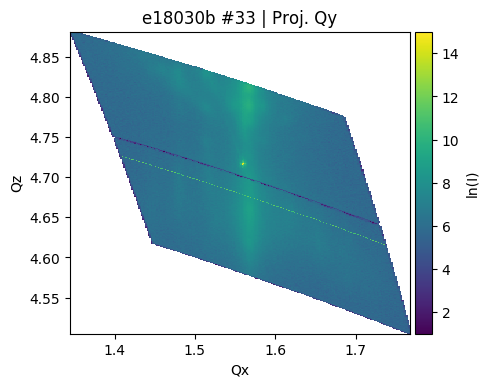

In [169]:
## along y
plt.figure(dpi=res)
ax=plt.gca()

# plt.pcolormesh(qxx[:,0,:], qzz[:,0,:],i[:,:,:].sum(1));
im = plt.pcolormesh(qxx[:,0,:], qzz[:,0,:],np.log(gint[:,:,:].sum(1)),vmin=1,vmax=15)
plt.title('{0} #{1} | Proj. Qy'.format(sample, scan_no))
plt.xlabel('Qx')
plt.ylabel('Qz')
plt.axis('image')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('ln(I)')

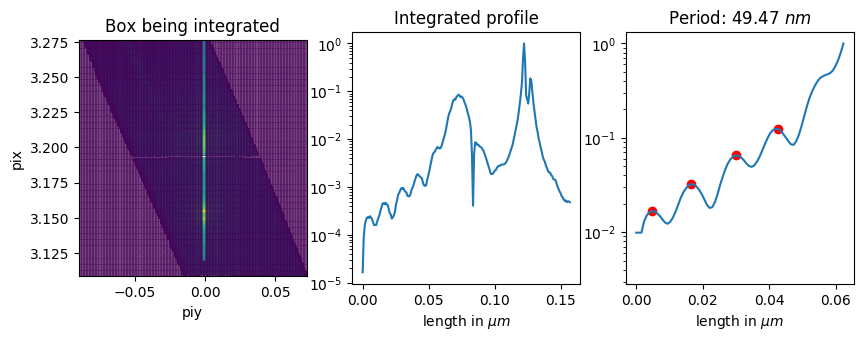

In [58]:
%matplotlib inline
n = 200
res = 100

# Select cut coordinates
start_q1, start_q2 = -0.001, 3.12
end_q1, end_q2 = -0.001, 3.277

# Make array of qx, qy values along line        
x = np.linspace(start_q1,end_q1,n) 
y = np.linspace(start_q2,end_q2,n)

# Data
q1 = qxx[:,0,:]
q2 = qzz[:,0,:]
I = gint.sum(1)[:-1,:-1]

# Calc
ind = np.sqrt((q2[:-1,:-1].ravel() - y[:,None])**2 + (q1[:-1,:-1].ravel() - x[:,None])**2) < (1e-3) #min along column
Icut_xy = ((I.ravel() * np.ones(ind.shape[0])[:,None]) * ind).sum(1)
box = ind.max(0).reshape(I.shape)
mask = np.ma.masked_where(box==1, box)
line = np.sqrt((x-x.min())**2+(y-y.max())**2)

## Calc
Ismooth = savgol_filter(Icut_xy,5,0)
Ismooth = Ismooth[120:]
idx = pk.indexes(Ismooth,thres=0.0005,min_dist=10)
# The periodicity - calc
order = np.array(range(len(idx)))
m,b = np.polyfit(order,line[idx],1)
period = abs(2 * np.pi / m)/10 # in nm

# Plot
fig, ax = plt.subplots(1,3,figsize=(12/1.2, 4/1.2),dpi=res)#,facecolor='lightgrey')
# fig.suptitle('hc3211 - {0} #{1} | 203 proj. Qz'.format(sample, scans))

ax[0].pcolormesh(q1,q2,np.log(I))
ax[0].pcolormesh(q1,q2,mask,alpha=0.2)
ax[0].set_title('Box being integrated')
ax[0].set_aspect('equal')
ax[0].set_xlabel('piy')
ax[0].set_ylabel('pix')

ax[1].plot(line,Icut_xy/Icut_xy.max())
ax[1].set_title('Integrated profile')
ax[1].set_xlabel(r'length in $\mu m$')
ax[1].set_yscale('log')

ax[2].plot(line[120:], Ismooth/Ismooth.max())
ax[2].scatter(line[120:][idx],Ismooth[idx]/Ismooth.max(),c='r')
ax[2].set_title(r'Period: {0} $nm$'.format(np.round(period,decimals=2)))
ax[2].set_xlabel(r'length in $\mu m$')
ax[2].set_yscale('log')

### SILX

In [68]:
from silx.gui import qt
from silx.gui.plot3d.ScalarFieldView import ScalarFieldView
from silx.gui.plot3d import SFViewParamTree

In [69]:
# Create the viewer main window
window = ScalarFieldView()

# Create a parameter tree for the scalar field view
treeView = SFViewParamTree.TreeView(window)
treeView.setSfView(window)  # Attach the parameter tree to the view

# Add the parameter tree to the main window in a dock widget
dock = qt.QDockWidget()
dock.setWindowTitle('Parameters')
dock.setWidget(treeView)
window.addDockWidget(qt.Qt.RightDockWidgetArea, dock)

# Set ScalarFieldView data
window.setData(i.transpose(2,1,0))

# Set scale of the data
window.setScale(qx[1]-qx[0], qy[1]-qy[0], qz[1]-qz[0])

# Set offset of the data
window.setTranslation(qx[0], qy[0], qz[0])

# Set axes labels
window.setAxesLabels('Qx', 'Qy', 'Qz')

# Add an iso-surface
window.addIsosurface(i.max()-i.mean(), '#FF0000FF')

window.show()